In [14]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import pydicom
import glob
import natsort
import cv2

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.applications.resnet50 import ResNet50
from sklearn.decomposition import PCA


import pickle

## Load DCM Files for Each Stage And Progression

In [15]:
def make_dict():
    # mapping of filepaths --> dcm files
    dcm_dict = {}
    PathDicom = "../ppmi/cd-pd/"
    for dirName, subdirList, fileList in os.walk(PathDicom):
        files = []
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                files.append(os.path.join(dirName,filename))
        if len(files) > 0:
            dcm_dict[dirName] = files
                
    return dcm_dict

In [16]:
def make_stage_dict(df, d):
    # mapping of subject --> filepaths --> dcm files
    dcm_dict = {}
    ids = set(df['Subject'])
    keys = list(d)
    for i in ids:
        id_list = {}
        for k in keys:
            if str(i) in k and 'T2' in k:
                id_list[k] = d[k]
        dcm_dict[i] = id_list
    
    return dcm_dict

In [17]:
d = make_dict()

In [18]:
mri_df = pd.read_csv('../ppmi/cd-pd/mri_t2_progression2.csv')
mri_df.head(10)

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage
0,3,406544,3817,Control,M,75,0,MRI,T2 in T1-anatomical space,Processed,1/15/2013,NiFTI,NaN,0,0
1,10,410941,3816,Control,M,66,0,MRI,T2 in T1-anatomical space,Processed,12/04/2012,NiFTI,NaN,0,0
2,26,344402,3813,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,10/16/2012,DCM,NaN,0,0
3,27,410769,3816,Control,M,66,0,MRI,T2 in corrected EPI space for I357776,Processed,12/04/2012,NiFTI,5/07/2019,0,0
4,32,357775,3816,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,12/04/2012,DCM,NaN,0,0
5,35,362628,3817,Control,M,75,0,MRI,Axial PD-T2 TSE,Original,1/15/2013,DCM,NaN,0,0
6,38,344405,3813,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,10/16/2012,DCM,NaN,0,0
7,39,357777,3816,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,12/04/2012,DCM,NaN,0,0
8,40,410536,3813,Control,M,66,0,MRI,T2 in corrected EPI space for I344404,Processed,10/16/2012,NiFTI,NaN,0,0
9,44,370983,3813,Control,M,66,0,MRI,T2 in T1-anatomical space,Processed,10/16/2012,NiFTI,NaN,0,0


In [19]:
len(set(mri_df['Subject']))

419

In [20]:
nifti_df = mri_df[mri_df['Format'] == 'NiFTI']
len(set(nifti_df['Subject']))

189

In [21]:
stage0 = mri_df[mri_df['Stage'] == 0]
stage1 = mri_df[mri_df['Stage'] == 1]
stage2 = mri_df[mri_df['Stage'] == 2]
stage3 = mri_df[mri_df['Stage'] == 3]

In [22]:
stage3

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage
19,90,249476,3612,PD,M,68,1,MRI,AX PD + T2,Original,6/15/2011,DCM,NaN,0,3
974,2329,243283,3607,PD,F,55,1,MRI,AX PD + T2,Original,4/26/2011,DCM,NaN,0,3
1145,2744,249475,3612,PD,M,68,1,MRI,AX PD + T2,Original,6/15/2011,DCM,NaN,0,3
1219,2881,243285,3607,PD,F,55,1,MRI,AX PD + T2,Original,4/26/2011,DCM,NaN,0,3


In [23]:
s0 = make_stage_dict(stage0, d)
s1 = make_stage_dict(stage1, d)
s2 = make_stage_dict(stage2, d)
s3 = make_stage_dict(stage3, d)

In [24]:
print('STAGED PATIENT INFO')
print('STAGES | stage 0: %d, stage 1: %d, stage 2: %d, stage 3: %d' % 
      (len(set(stage0['Subject'])), len(set(stage1['Subject'])), len(set(stage2['Subject'])), len(set(stage3['Subject']))))


STAGED PATIENT INFO
STAGES | stage 0: 148, stage 1: 122, stage 2: 149, stage 3: 2


In [25]:
stage0[stage0['Subject'] == 3000]

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage
79,221,224561,3000,Control,F,69,1,MRI,AX T2 FLAIR,Original,2/01/2011,DCM,NaN,0,0


In [26]:
s0[3104].keys()

dict_keys(['../ppmi/cd-pd/PPMI/3104/Axial_PD-T2_TSE/2011-02-14_12_32_37.0/S103321', '../ppmi/cd-pd/PPMI/3104/Axial_PD-T2_TSE/2012-04-20_10_01_40.0/S148995'])

In [27]:
def make_flattened_stage_list(df, d):
    dcm_l = []
    dcm_Y = []
    ids = df['Subject'].unique()
    keys = list(d)
    for i in ids:
        for k in keys:
            if k.split('/')[4] == str(i) in k and 'T2' in k:
                dcm_l.append(k)
                person = df[df['Subject'] == i]['Progression']
                dcm_Y.append(sum(person)/len(person))
    return dcm_l, dcm_Y

In [28]:
s0_dcm, s0_Y = make_flattened_stage_list(stage0, d)
# s0_dcm[:10]

In [29]:
st = '../ppmi/cd-pd/PPMI/3387/MPRAGE_GRAPPA/2015-04-30_08_36_59.0/S264326'
st.split('/')[4]

'3387'

In [30]:
sum(s0_Y)

14.0

In [31]:
s1_dcm, s1_Y = make_flattened_stage_list(stage1, d)
print(sum(s1_Y), len(s1_Y))
s2_dcm, s2_Y = make_flattened_stage_list(stage2, d)
print(sum(s2_Y), len(s2_Y))
s3_dcm, s3_Y = make_flattened_stage_list(stage3, d)
print(sum(s3_Y), len(s3_Y))

113.0 268
13.0 343
0.0 2


In [32]:
stage1[stage1['Subject'] == 3000]

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage


In [33]:
for x in s1_dcm:
    if '3218' in x:
        print(x)

## CNN for Stage 0

In [35]:
file1 = s0_dcm[192]
file2 = s0_dcm[32]
files = [file1, file2]
files

['../ppmi/cd-pd/PPMI/3850/Axial_PD-T2_TSE/2012-06-01_08_52_37.0/S171230',
 '../ppmi/cd-pd/PPMI/3767/Axial_PD-T2_TSE/2013-01-16_09_06_28.0/S181440']

In [79]:
def load_scan(path, imgs_ls):
    print('loading scan...')
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            imgs_ls.append(os.path.join(dirName, filename))
            
    return imgs_ls

Visualizing two different DCM files for patients

NEW PATIENT
getting image for ...  ../ppmi/cd-pd/PPMI/3850/Axial_PD-T2_TSE/2012-06-01_08_52_37.0/S171230
getting x, y, z vals
SIZE:  (256, 228, 96)


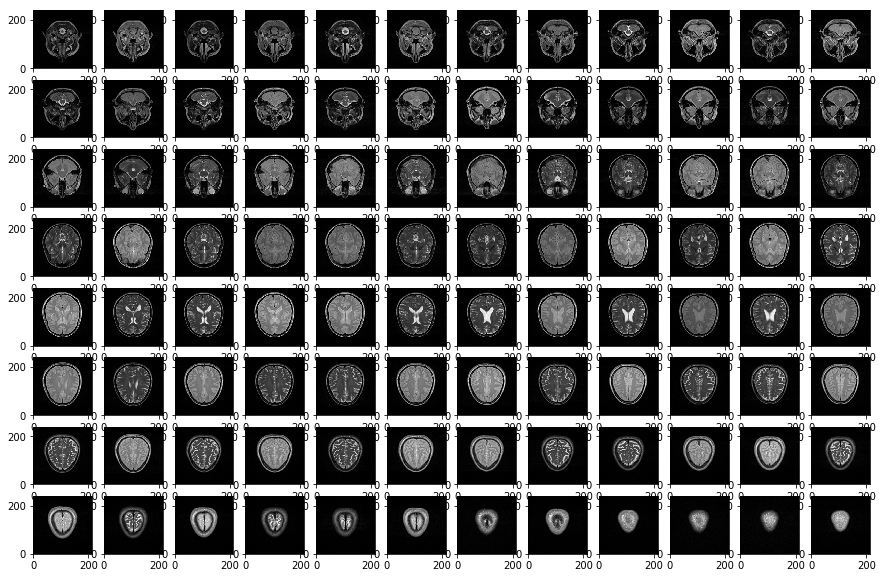

NEW PATIENT
getting image for ...  ../ppmi/cd-pd/PPMI/3767/Axial_PD-T2_TSE/2013-01-16_09_06_28.0/S181440
getting x, y, z vals
SIZE:  (256, 228, 96)


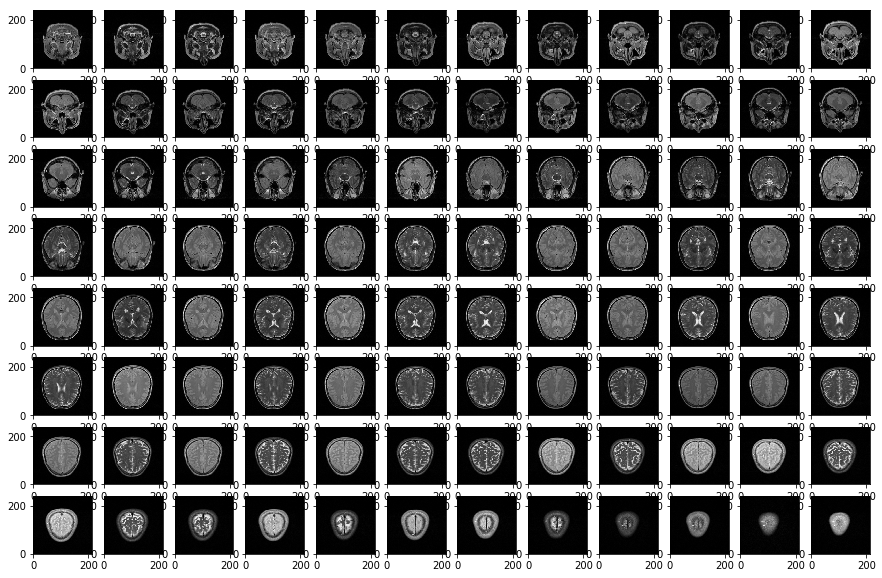

In [80]:
for pathname in files:
    print('NEW PATIENT')
    print('getting image for ... ', pathname)
    imgs = os.listdir(pathname)
    imgs.sort()
    
    imgs_ls = []
    first_patient = d[pathname]
        
#     first_patient = sorted(files, key=lambda f:f.SliceLocation)

#     dcms = []
#     for f in first_patient:
#         dcms.append(pydicom.read_file(f))
        
#     dcms = sorted(dcms, key=lambda d: d.SliceLocation)
    
    RefDs = pydicom.read_file(first_patient[0])

    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(first_patient))

    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]),
                         float(RefDs.PixelSpacing[1]),
                         float(RefDs.SliceThickness))
    
    print('getting x, y, z vals')
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*
               ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*
                   ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*
                   ConstPixelSpacing[2], ConstPixelSpacing[2])
    
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    
    print('SIZE: ', ArrayDicom.shape)
    
    dcms = []
    for file in first_patient:
        dcms.append(pydicom.read_file(file))
    
    dcms = sorted(dcms, key=lambda d: d.SliceLocation)

#     # go through DCM files
#     for file in first_patient:
#         ds = pydicom.read_file(file)
#         ArrayDicom[:, :, first_patient.index(file)] = ds.pixel_array

    for ds in dcms:
        ArrayDicom[:, :, dcms.index(ds)] = ds.pixel_array

    plt.figure(figsize=(15,10))
    plt.axes().set_aspect('equal', 'datalim')
    plt.set_cmap(plt.gray())
    for i in range(len(first_patient)):
        plt.subplot(8,12,i+1)
        plt.pcolormesh(y, x, ArrayDicom[:, :, i]) 
    plt.show()
    

In [39]:
image_shapes = {}
new_s0_dcm = []
new_s0_Y = []
new_image_shapes = {}
for i, file in enumerate(s0_dcm):
    print(i, file)
    p1 = d[file]
    
    RefDs = pydicom.read_file(p1[0])

    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(p1))
    
    try:

        ConstPixelSpacing = (float(RefDs.PixelSpacing[0]),
                             float(RefDs.PixelSpacing[1]),
                             float(RefDs.SliceThickness))

        x = np.arange(0.0, (ConstPixelDims[0]+1)*
                   ConstPixelSpacing[0], ConstPixelSpacing[0])
        y = np.arange(0.0, (ConstPixelDims[1]+1)*
                       ConstPixelSpacing[1], ConstPixelSpacing[1])
        z = np.arange(0.0, (ConstPixelDims[2]+1)*
                       ConstPixelSpacing[2], ConstPixelSpacing[2])

        ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

        image_shapes[i] = ArrayDicom.shape
        
        if ArrayDicom.shape[2] > 50:
            new_s0_dcm.append(file)
            new_s0_Y.append(s0_Y[i])
            new_image_shapes[i] = ArrayDicom.shape
        
        
    except:
        continue

0 ../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2011-12-19_12_20_46.0/S171113
1 ../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2013-01-15_11_39_31.0/S184113
2 ../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2012-12-04_10_24_51.0/S181446
3 ../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2011-11-28_12_29_42.0/S171108
4 ../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2011-10-24_12_32_32.0/S135561
5 ../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2012-10-16_11_11_16.0/S173570
6 ../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2011-09-13_14_07_00.0/S142581
7 ../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2012-10-01_08_34_07.0/S173557
8 ../ppmi/cd-pd/PPMI/3478/sT2W_PD_TSE/2012-11-27_11_52_13.0/S183656
9 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2011-06-27_07_45_09.0/S113801
10 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2012-05-23_10_29_19.0/S157063
11 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2011-01-18_13_23_18.0/S103328
12 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2012-02-01_14_20_48.0/S173513
13 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FLAIR/2011-08-18_13_40_02.0/S190

127 ../ppmi/cd-pd/PPMI/3161/Axial_PD-T2_TSE/2011-07-28_10_52_10.0/S117821
128 ../ppmi/cd-pd/PPMI/3161/Axial_PD-T2_TSE/2012-09-04_08_45_02.0/S167645
129 ../ppmi/cd-pd/PPMI/3636/AX_PD_+_T2/2013-02-22_14_19_29.0/S183694
130 ../ppmi/cd-pd/PPMI/3458/sT2W_PD_TSE/2011-05-10_11_00_58.0/S110183
131 ../ppmi/cd-pd/PPMI/3216/Ax_T2_FLAIR/2011-08-26_10_09_54.0/S139703
132 ../ppmi/cd-pd/PPMI/3216/_AX_FSE_T2/2011-08-26_10_09_54.0/S139702
133 ../ppmi/cd-pd/PPMI/3779/Axial_PD-T2_TSE_FS/2013-06-26_09_18_51.0/S196346
134 ../ppmi/cd-pd/PPMI/3779/Axial_PD-T2_TSE/2012-06-13_09_30_57.0/S160423
135 ../ppmi/cd-pd/PPMI/3807/Axial_PD-T2_TSE/2011-07-26_11_50_02.0/S131565
136 ../ppmi/cd-pd/PPMI/3807/Axial_PD-T2_TSE/2012-08-07_10_19_17.0/S171222
137 ../ppmi/cd-pd/PPMI/3768/Axial_PD-T2_TSE/2013-01-16_07_56_24.0/S181444
138 ../ppmi/cd-pd/PPMI/3768/Axial_PD-T2_TSE/2011-12-21_08_36_30.0/S148985
139 ../ppmi/cd-pd/PPMI/3613/AX_PD_+_T2/2011-06-16_08_12_58.0/S117983
140 ../ppmi/cd-pd/PPMI/3613/AX_PD_+_T2/2011-06-16_08_12_58

260 ../ppmi/cd-pd/PPMI/3004/AX_T2_AC-PC_line_Entire_Brain/2011-04-05_14_45_45.0/S113509
261 ../ppmi/cd-pd/PPMI/3611/AX_PD_+_T2/2011-05-25_13_13_30.0/S113599
262 ../ppmi/cd-pd/PPMI/3619/Ax_T2_FLAIR/2011-11-21_16_43_52.0/S135410
263 ../ppmi/cd-pd/PPMI/3424/AXIAL__T2__FSE/2011-07-13_10_01_53.0/S124946
264 ../ppmi/cd-pd/PPMI/3201/Ax_T2_FLAIR/2010-12-02_10_58_37.0/S101956
265 ../ppmi/cd-pd/PPMI/3318/Axial_PD-T2_TSE_AC_PC_line/2012-06-27_11_57_20.0/S157088
266 ../ppmi/cd-pd/PPMI/3318/Axial_PD-T2_TSE_FS/2013-04-18_10_07_18.0/S191159
267 ../ppmi/cd-pd/PPMI/3318/Axial_PD-T2_TSE_FS/2014-04-15_14_21_28.0/S228156


In [40]:
set(image_shapes.values())

{(228, 256, 18),
 (228, 256, 96),
 (228, 256, 108),
 (240, 240, 58),
 (240, 240, 116),
 (240, 240, 120),
 (256, 192, 100),
 (256, 204, 48),
 (256, 204, 96),
 (256, 204, 102),
 (256, 204, 104),
 (256, 228, 48),
 (256, 228, 54),
 (256, 228, 95),
 (256, 228, 96),
 (256, 228, 99),
 (256, 228, 100),
 (256, 228, 104),
 (256, 228, 108),
 (256, 228, 110),
 (256, 232, 108),
 (256, 256, 28),
 (256, 256, 30),
 (256, 256, 32),
 (256, 256, 35),
 (256, 256, 36),
 (256, 256, 38),
 (256, 256, 64),
 (256, 256, 72),
 (256, 256, 76),
 (512, 512, 18),
 (512, 512, 23),
 (512, 512, 24),
 (512, 512, 25),
 (512, 512, 28),
 (512, 512, 29),
 (512, 512, 30),
 (512, 512, 32),
 (512, 512, 36),
 (512, 512, 48),
 (512, 512, 52),
 (512, 512, 54),
 (512, 512, 56),
 (512, 512, 57),
 (512, 512, 58),
 (512, 512, 59),
 (512, 512, 60),
 (512, 512, 64),
 (512, 512, 72),
 (512, 512, 81),
 (512, 512, 84),
 (560, 560, 38)}

In [41]:
def filter_images(s_dcm, s_Y):
    image_shapes = {}
    new_s0_dcm = []
    new_s0_Y = []
    new_image_shapes = {}
    for i, file in enumerate(s_dcm):
        print(i, file)
        p1 = d[file]

        RefDs = pydicom.read_file(p1[0])

        ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(p1))

        try:

            ConstPixelSpacing = (float(RefDs.PixelSpacing[0]),
                                 float(RefDs.PixelSpacing[1]),
                                 float(RefDs.SliceThickness))

            x = np.arange(0.0, (ConstPixelDims[0]+1)*
                       ConstPixelSpacing[0], ConstPixelSpacing[0])
            y = np.arange(0.0, (ConstPixelDims[1]+1)*
                           ConstPixelSpacing[1], ConstPixelSpacing[1])
            z = np.arange(0.0, (ConstPixelDims[2]+1)*
                           ConstPixelSpacing[2], ConstPixelSpacing[2])

            ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

            image_shapes[i] = ArrayDicom.shape

            if ArrayDicom.shape[2] > 50:
                new_s0_dcm.append(file)
                new_s0_Y.append(s_Y[i])
                new_image_shapes[i] = ArrayDicom.shape


        except:
            continue
            
    return image_shapes, new_image_shapes, new_s0_dcm, new_s0_Y

In [42]:
s1_img, new_s1, s1_dcm, s1_y = filter_images(s1_dcm, s1_Y)

0 ../ppmi/cd-pd/PPMI/3970/AX_T2_FLAIR/2013-03-13_07_51_50.0/S193079
1 ../ppmi/cd-pd/PPMI/3970/Ax_PD__T2/2013-03-13_07_51_50.0/S193077
2 ../ppmi/cd-pd/PPMI/3233/Ax_T2_FLAIR/2012-10-26_07_45_21.0/S186531
3 ../ppmi/cd-pd/PPMI/3233/_AX_FSE_T2/2012-10-26_07_45_21.0/S186530
4 ../ppmi/cd-pd/PPMI/3419/Ax_FSE_T2/2011-05-02_10_31_18.0/S110181
5 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2014-04-23_10_13_18.0/S221707
6 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2016-08-24_10_47_33.0/S501573
7 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2012-04-18_10_40_04.0/S148978
8 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2013-05-10_10_55_48.0/S191155
9 ../ppmi/cd-pd/PPMI/3957/AX_T2_FLAIR/2012-06-27_08_23_57.0/S184911
10 ../ppmi/cd-pd/PPMI/3957/Ax_PD__T2/2012-06-27_08_23_57.0/S184909
11 ../ppmi/cd-pd/PPMI/3130/Axial_PD-T2_TSE_FS/2013-11-13_11_14_21.0/S214283
12 ../ppmi/cd-pd/PPMI/3130/Axial_PD-T2_TSE_FS/2012-11-16_10_03_25.0/S180776
13 ../ppmi/cd-pd/PPMI/3130/Axial_PD-T2_TSE_FS/2016-12-15_11_46_20.0/S547134
14 ../pp

121 ../ppmi/cd-pd/PPMI/3269/AX_FLAIR_T2/2011-09-06_12_02_27.0/S124916
122 ../ppmi/cd-pd/PPMI/3406/AXIAL__T2__FSE/2010-08-10_17_54_27.0/S113567
123 ../ppmi/cd-pd/PPMI/3815/Axial_PD-T2_TSE_FS/2015-11-03_10_57_29.0/S331842
124 ../ppmi/cd-pd/PPMI/3815/Axial_PD-T2_TSE_FS/2013-11-05_10_25_18.0/S208424
125 ../ppmi/cd-pd/PPMI/3815/Axial_PD-T2_TSE/2012-11-06_11_22_37.0/S179213
126 ../ppmi/cd-pd/PPMI/3815/Axial_PD-T2_TSE/2011-11-08_11_13_28.0/S171105
127 ../ppmi/cd-pd/PPMI/3954/AX_T2_FLAIR/2012-01-19_07_15_58.0/S139761
128 ../ppmi/cd-pd/PPMI/3954/Ax_PD__T2/2012-01-19_07_15_58.0/S139762
129 ../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2012-05-23_11_24_20.0/S157050
130 ../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2011-05-26_13_20_29.0/S113786
131 ../ppmi/cd-pd/PPMI/3223/Ax_T2_FLAIR/2012-01-25_10_31_58.0/S189265
132 ../ppmi/cd-pd/PPMI/3223/_Ax_T2_FSE/2012-01-25_10_31_58.0/S189266
133 ../ppmi/cd-pd/PPMI/3176/Axial_PD-T2-FS_TSE/2014-09-09_11_08_58.0/S234699
134 ../ppmi/cd-pd/PPMI/3176/Axial_PD-T2_TSE/2013-05-2

246 ../ppmi/cd-pd/PPMI/3203/Ax_T2_FLAIR/2011-01-06_12_34_23.0/S101871
247 ../ppmi/cd-pd/PPMI/3622/AX_PD_+_T2/2012-02-03_11_26_34.0/S142373
248 ../ppmi/cd-pd/PPMI/3665/PD-T2_DUAL_AXIAL_TSE/2013-03-13_15_15_17.0/S186545
249 ../ppmi/cd-pd/PPMI/3445/AXIAL__T2__FSE/2012-03-21_19_40_13.0/S180297
250 ../ppmi/cd-pd/PPMI/3459/sT2W_PD_TSE/2011-05-16_14_29_13.0/S128037
251 ../ppmi/cd-pd/PPMI/3469/sT2W_PD_TSE/2012-02-07_11_00_13.0/S142361
252 ../ppmi/cd-pd/PPMI/3631/AX_PD_+_T2/2012-09-13_17_20_51.0/S178132
253 ../ppmi/cd-pd/PPMI/3207/Ax_T2_FLAIR/2011-03-07_10_03_16.0/S189260
254 ../ppmi/cd-pd/PPMI/3227/Ax_T2_FLAIR/2012-05-25_11_39_41.0/S189271
255 ../ppmi/cd-pd/PPMI/3444/AXIAL__T2__FSE/2012-03-14_09_24_35.0/S170944
256 ../ppmi/cd-pd/PPMI/3664/PD-T2_DUAL_AXIAL_TSE/2013-02-25_11_28_17.0/S184908
257 ../ppmi/cd-pd/PPMI/3454/sT2W_PD_TSE/2011-01-07_14_39_34.0/S101978
258 ../ppmi/cd-pd/PPMI/3711/T2W_FLAIR/2013-03-28_17_09_08.0/S326044
259 ../ppmi/cd-pd/PPMI/3704/T2W_FLAIR/2013-04-23_11_32_22.0/S199199
26

In [43]:
len(s1_dcm), len(s1_y)

(209, 209)

In [44]:
file = open('ids/train_ids2.txt', 'w') 
for line in s2_dcm[:180]:
    file.write(line + '\n')
# new_s0_dcm

In [45]:
new_s0_dcm

['../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2011-12-19_12_20_46.0/S171113',
 '../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2013-01-15_11_39_31.0/S184113',
 '../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2012-12-04_10_24_51.0/S181446',
 '../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2011-11-28_12_29_42.0/S171108',
 '../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2011-10-24_12_32_32.0/S135561',
 '../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2012-10-16_11_11_16.0/S173570',
 '../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2011-09-13_14_07_00.0/S142581',
 '../ppmi/cd-pd/PPMI/3478/sT2W_PD_TSE/2012-11-27_11_52_13.0/S183656',
 '../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2011-06-27_07_45_09.0/S113801',
 '../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2012-05-23_10_29_19.0/S157063',
 '../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2011-01-18_13_23_18.0/S103328',
 '../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2012-02-01_14_20_48.0/S173513',
 '../ppmi/cd-pd/PPMI/3215/Ax_T2_FSE/2011-08-18_13_40_02.0/S190599',
 '../ppmi/cd-pd/PPMI/3213/Ax_T2_FLAIR/2011-08-16

Resize the Images

In [46]:
X = []
for i, filepath in enumerate(new_s0_dcm):
    print(i, filepath)
    pt = []
    dcm_files = d[pathname]
    
    temp = []
    for file in dcm_files:
        ds = pydicom.read_file(file)
        temp.append(ds)
        
    temp = sorted(temp, key=lambda d: d.SliceLocation)
    
    for ds in temp:
        arr = ds.pixel_array
        new = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        pt.append(new)
    
    pt = np.array(pt)  
    pt = pt[:50]
    
    X.append(pt)

0 ../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2011-12-19_12_20_46.0/S171113


NameError: name 'pathname' is not defined

In [36]:
def make_X(new_dcm):
    X = []
    for i, filepath in enumerate(new_dcm):
        print(i, filepath)
        pt = []
        dcm_files = d[pathname]

        temp = []
        for file in dcm_files:
            ds = pydicom.read_file(file)
            temp.append(ds)

        temp = sorted(temp, key=lambda d: d.SliceLocation)

        for ds in temp:
            arr = ds.pixel_array
            new = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            pt.append(new)

        pt = np.array(pt)  
        pt = pt[:50]

        X.append(pt)
    return X

In [37]:
def make_X_flat(new_dcm, y):
    X = []
    Y = []
    for i, filepath in enumerate(new_dcm):
        print(i, filepath)
#         pt = []
        dcm_files = d[pathname]

        temp = []
        for file in dcm_files:
            ds = pydicom.read_file(file)
            temp.append(ds)

        temp = sorted(temp, key=lambda d: d.SliceLocation)
        temp = temp[:50]
        
        for ds in temp:
            arr = ds.pixel_array
            new = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
#             pt.append(new)
            X.append(new)
            Y.append(y[i])
        

#         pt = np.array(pt)  
#         pt = pt[:50]

#         X.append(pt)
    return X, Y

In [38]:
s1_img, new_s1, s1_dcm, s1_y
s1_X =  make_X(s1_dcm)

NameError: name 's1_img' is not defined

In [64]:
len(s1_dcm)*50

12550

In [95]:
s1_X = np.array(s1_X)
# s1_X = s1_X.reshape(-1, 256,256,1)
s1_X.shape

(209, 50, 256, 256)

In [97]:
# s1_X = np.array(s1_X)
s1_Y = np.array(s1_y)
inpt = {'input': s1_X, 'output': s1_Y}

with open('stage1.pickle', 'wb') as handle:
    pickle.dump(inpt, handle)

print(s1_X.shape, s1_Y.shape)

(209, 50, 256, 256) (209,)


In [105]:
s2_img, new_s2, s2_dcm, s2_y = filter_images(s2_dcm, s2_Y)

0 ../ppmi/cd-pd/PPMI/4065/Axial_PD-T2_TSE_FS/2012-12-10_11_33_32.0/S180854
1 ../ppmi/cd-pd/PPMI/3228/Ax_T2_FLAIR/2012-06-26_08_14_11.0/S176062
2 ../ppmi/cd-pd/PPMI/3228/Ax_T2_FSE/2012-06-26_08_14_11.0/S176064
3 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE_FS/2013-07-05_08_45_20.0/S203272
4 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE_FS/2014-08-13_08_43_53.0/S228164
5 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE/2012-03-22_10_20_46.0/S145729
6 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE_FS/2015-03-30_15_27_11.0/S258987
7 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE_FS/2015-03-30_15_27_11.0/S258984
8 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE_FS/2013-04-18_12_01_06.0/S189363
9 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE/2011-03-24_13_04_58.0/S103325
10 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE/2012-04-18_11_44_39.0/S148998
11 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2016-05-18_11_39_01.0/S467578
12 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2014-05-21_12_19_59.0/S228107
13 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2

112 ../ppmi/cd-pd/PPMI/3108/Axial_PD-T2_TSE/2012-05-25_10_46_49.0/S157044
113 ../ppmi/cd-pd/PPMI/3108/Axial_PD-T2_TSE/2011-04-20_10_07_57.0/S107266
114 ../ppmi/cd-pd/PPMI/3321/Axial_PD-T2_TSE_AC_PC_line/2012-06-14_14_06_59.0/S191039
115 ../ppmi/cd-pd/PPMI/3321/Axial_PD-T2_TSE_FS/2014-08-07_10_45_51.0/S234713
116 ../ppmi/cd-pd/PPMI/3285/AX_T2_DE/2012-11-27_10_32_58.0/S186539
117 ../ppmi/cd-pd/PPMI/3285/AX_FLAIR_T2/2012-11-27_10_32_58.0/S186541
118 ../ppmi/cd-pd/PPMI/3374/Axial_PD-T2_TSE_FS/2014-04-16_09_39_42.0/S221714
119 ../ppmi/cd-pd/PPMI/3374/Axial_PD-T2_TSE_FS/2016-04-13_09_42_15.0/S426401
120 ../ppmi/cd-pd/PPMI/3374/Axial_PD-T2_TSE_FS/2013-07-29_10_39_31.0/S203268
121 ../ppmi/cd-pd/PPMI/3374/Axial_PD-T2_TSE/2012-04-19_09_50_48.0/S148979
122 ../ppmi/cd-pd/PPMI/3951/AX_T2_FLAIR/2011-09-27_08_21_21.0/S180334
123 ../ppmi/cd-pd/PPMI/3951/Ax_PD__T2/2011-09-27_08_21_21.0/S180336
124 ../ppmi/cd-pd/PPMI/4035/AXIAL_PD-T2_TSE_FS/2017-03-21_12_58_45.0/S606307
125 ../ppmi/cd-pd/PPMI/4035/Axial

237 ../ppmi/cd-pd/PPMI/3224/_AX_FSE_T2/2012-04-30_10_58_42.0/S189268
238 ../ppmi/cd-pd/PPMI/3567/Axial_PD-T2_TSE_FS/2015-06-29_14_56_08.0/S270431
239 ../ppmi/cd-pd/PPMI/3567/Axial_PD-T2_TSE_FS/2013-07-09_16_59_40.0/S208409
240 ../ppmi/cd-pd/PPMI/3567/Axial_PD-T2_TSE/2012-06-25_16_15_22.0/S171177
241 ../ppmi/cd-pd/PPMI/3567/Axial_PD-T2_TSE/2011-06-01_09_22_09.0/S117838
242 ../ppmi/cd-pd/PPMI/4123/AXIAL_FSE_T2_FS/2013-03-11_18_41_12.0/S190740
243 ../ppmi/cd-pd/PPMI/3028/Ax_T2_Fse_thin_ac-pc/2013-03-25_09_36_23.0/S187819
244 ../ppmi/cd-pd/PPMI/3254/AX_T2_DE/2011-01-28_12_35_01.0/S101975
245 ../ppmi/cd-pd/PPMI/3254/AX_FLAIR_T2/2011-01-28_12_35_01.0/S101974
246 ../ppmi/cd-pd/PPMI/3710/T2W_TSE/2013-07-09_14_37_49.0/S199205
247 ../ppmi/cd-pd/PPMI/3502/AX_T2/2010-11-10_10_15_05.0/S101914
248 ../ppmi/cd-pd/PPMI/3116/Axial_PD-T2_TSE_FS/2013-11-13_12_55_49.0/S214310
249 ../ppmi/cd-pd/PPMI/3116/Axial_PD-T2_TSE_FS/2015-12-09_10_12_52.0/S360800
250 ../ppmi/cd-pd/PPMI/3116/Axial_PD-T2_TSE_FS/2012-11-

In [107]:
s2_X = make_X(s2_dcm)
s2_X = np.array(s2_X)
# s2_X = s2_X.reshape(-1, 256,256,1)
s2_X.shape

0 ../ppmi/cd-pd/PPMI/4065/Axial_PD-T2_TSE_FS/2012-12-10_11_33_32.0/S180854
1 ../ppmi/cd-pd/PPMI/3228/Ax_T2_FSE/2012-06-26_08_14_11.0/S176064
2 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE_FS/2013-07-05_08_45_20.0/S203272
3 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE_FS/2014-08-13_08_43_53.0/S228164
4 ../ppmi/cd-pd/PPMI/3375/Axial_PD-T2_TSE/2012-03-22_10_20_46.0/S145729
5 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE_FS/2015-03-30_15_27_11.0/S258984
6 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE_FS/2013-04-18_12_01_06.0/S189363
7 ../ppmi/cd-pd/PPMI/3105/Axial_PD-T2_TSE/2012-04-18_11_44_39.0/S148998
8 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2016-05-18_11_39_01.0/S467578
9 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2014-05-21_12_19_59.0/S228107
10 ../ppmi/cd-pd/PPMI/3120/Axial_PD-T2_TSE_FS/2013-04-17_10_25_22.0/S191137
11 ../ppmi/cd-pd/PPMI/3278/AX_T2_DE/2011-12-12_11_36_53.0/S148904
12 ../ppmi/cd-pd/PPMI/3564/Axial_PD-T2_TSE_FS/2013-05-16_13_44_52.0/S208404
13 ../ppmi/cd-pd/PPMI/3564/Axial_PD-T2_TSE/2011

110 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2014-03-11_08_57_35.0/S217935
111 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2013-01-21_13_34_00.0/S181391
112 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2017-02-20_13_22_36.0/S606343
113 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2015-02-23_07_32_03.0/S308755
114 ../ppmi/cd-pd/PPMI/3770/Axial_PD-T2_TSE_FS/2013-02-27_08_04_21.0/S185769
115 ../ppmi/cd-pd/PPMI/3770/Axial_PD-T2_TSE_FS/2014-02-19_07_53_30.0/S216369
116 ../ppmi/cd-pd/PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_11.0/S160385
117 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2015-04-29_08_32_35.0/S264321
118 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2013-07-31_08_57_43.0/S203304
119 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2012-06-07_08_12_12.0/S157069
120 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2011-04-18_10_52_24.0/S117963
121 ../ppmi/cd-pd/PPMI/3476/sT2W_PD_TSE/2012-09-20_10_57_38.0/S170956
122 ../ppmi/cd-pd/PPMI/3556/Axial_PD-T2_TSE_FS/2015-01-12_15_02_33.0/S254406
123 ../ppmi/cd-

220 ../ppmi/cd-pd/PPMI/3559/Axial_PD-T2_TSE_FS/2015-03-17_10_30_10.0/S259009
221 ../ppmi/cd-pd/PPMI/3559/Axial_PD-T2_TSE_FS/2013-03-11_15_23_17.0/S189398
222 ../ppmi/cd-pd/PPMI/3559/Axial_PD-T2_TSE/2011-03-09_10_35_20.0/S113971
223 ../ppmi/cd-pd/PPMI/3559/Axial_PD-T2_TSE/2012-03-16_08_15_01.0/S152253
224 ../ppmi/cd-pd/PPMI/3617/AX_PD_+_T2/2011-10-05_15_03_24.0/S128052
225 ../ppmi/cd-pd/PPMI/3856/Axial_PD-T2_TSE_FS/2011-08-11_08_16_54.0/S193065
226 ../ppmi/cd-pd/PPMI/3856/Axial_PD-T2_TSE_FS/2011-08-11_08_16_54.0/S193067
227 ../ppmi/cd-pd/PPMI/3605/AXIAL_PD-T2_TSE_FS/2016-03-23_09_51_40.0/S426406
228 ../ppmi/cd-pd/PPMI/3605/AX_PD_+_T2/2011-03-21_11_24_44.0/S102940
229 ../ppmi/cd-pd/PPMI/3268/AX_T2_DE/2011-08-08_12_22_05.0/S124913
230 ../ppmi/cd-pd/PPMI/3461/sT2W_PD_TSE/2011-06-10_11_55_43.0/S190654
231 ../ppmi/cd-pd/PPMI/3392/Axial_PD-T2_TSE_FS/2014-05-19_09_31_47.0/S225605
232 ../ppmi/cd-pd/PPMI/3392/Axial_PD-T2_TSE_FS/2013-04-29_10_17_16.0/S189912
233 ../ppmi/cd-pd/PPMI/3392/Axial_PD-T

(261, 50, 256, 256)

In [108]:
s2_X = np.array(s2_X)
s2_Y = np.array(s2_y)

inpt = {'input': s2_X, 'output': s2_Y}

with open('stage2.pickle', 'wb') as handle:
    pickle.dump(inpt, handle)

print(s2_X.shape, s2_Y.shape)

(261, 50, 256, 256) (261,)


In [113]:
s0_img, new_s0, s0_dcm, s0_y = filter_images(s0_dcm, s0_Y)
s0_X = make_X(s0_dcm)
s0_X = np.array(s0_X)
# s3_X = s3_X.reshape(-1, 256,256,1)
s0_X.shape

0 ../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2011-12-19_12_20_46.0/S171113
1 ../ppmi/cd-pd/PPMI/3817/Axial_PD-T2_TSE/2013-01-15_11_39_31.0/S184113
2 ../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2012-12-04_10_24_51.0/S181446
3 ../ppmi/cd-pd/PPMI/3816/Axial_PD-T2_TSE/2011-11-28_12_29_42.0/S171108
4 ../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2011-10-24_12_32_32.0/S135561
5 ../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2012-10-16_11_11_16.0/S173570
6 ../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2011-09-13_14_07_00.0/S142581
7 ../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2012-10-01_08_34_07.0/S173557
8 ../ppmi/cd-pd/PPMI/3478/sT2W_PD_TSE/2012-11-27_11_52_13.0/S183656
9 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2011-06-27_07_45_09.0/S113801
10 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2012-05-23_10_29_19.0/S157063
11 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2011-01-18_13_23_18.0/S103328
12 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2012-02-01_14_20_48.0/S173513
13 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FLAIR/2011-08-18_13_40_02.0/S190

161 ../ppmi/cd-pd/PPMI/3756/Axial_PD-T2_TSE/2011-10-19_10_33_42.0/S131526
162 ../ppmi/cd-pd/PPMI/3368/Axial_PD-T2_TSE_FS/2013-01-31_09_29_01.0/S188421
163 ../ppmi/cd-pd/PPMI/3368/Axial_PD-T2_TSE/2011-09-21_09_46_51.0/S128406
164 ../ppmi/cd-pd/PPMI/3156/Axial_PD-T2_TSE/2011-01-18_15_19_52.0/S113834
165 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE_FS/2015-03-30_14_21_51.0/S258994
166 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE_FS/2015-03-30_14_21_51.0/S258990
167 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE/2012-04-18_12_47_15.0/S149003
168 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE/2011-03-24_14_13_48.0/S109068
169 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE_FS/2015-08-19_09_38_22.0/S277078
170 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2011-03-24_08_10_02.0/S117957
171 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2012-03-19_11_57_34.0/S146650
172 ../ppmi/cd-pd/PPMI/3172/Axial_PD-T2_TSE/2013-01-31_11_20_12.0/S181418
173 ../ppmi/cd-pd/PPMI/3172/Axial_PD-T2_TSE/2012-01-04_10_37_56.0/S139297
174 ../ppmi/cd-pd/PPMI/362

5 ../ppmi/cd-pd/PPMI/3813/Axial_PD-T2_TSE/2012-10-16_11_11_16.0/S173570
6 ../ppmi/cd-pd/PPMI/3572/Axial_PD-T2_TSE/2011-09-13_14_07_00.0/S142581
7 ../ppmi/cd-pd/PPMI/3478/sT2W_PD_TSE/2012-11-27_11_52_13.0/S183656
8 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2011-06-27_07_45_09.0/S113801
9 ../ppmi/cd-pd/PPMI/3112/Axial_PD-T2_TSE/2012-05-23_10_29_19.0/S157063
10 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2011-01-18_13_23_18.0/S103328
11 ../ppmi/cd-pd/PPMI/3300/Axial_PD-T2_TSE/2012-02-01_14_20_48.0/S173513
12 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FSE/2011-08-18_13_40_02.0/S190599
13 ../ppmi/cd-pd/PPMI/3213/Ax_T2_FLAIR/2011-08-16_10_46_27.0/S139700
14 ../ppmi/cd-pd/PPMI/3271/AX_T2_DE/2011-09-21_12_30_14.0/S124935
15 ../ppmi/cd-pd/PPMI/3615/AX_PD_+_T2/2011-07-28_09_31_16.0/S124978
16 ../ppmi/cd-pd/PPMI/3450/sT2W_PD_TSE/2010-11-05_13_13_27.0/S101874
17 ../ppmi/cd-pd/PPMI/3466/sT2W_PD_TSE/2011-11-30_13_40_24.0/S153803
18 ../ppmi/cd-pd/PPMI/3624/AX_PD_+_T2/2012-02-07_15_59_26.0/S142376
19 ../ppmi/cd-pd/PPMI/

117 ../ppmi/cd-pd/PPMI/3464/sT2W_PD_TSE/2011-10-18_12_05_11.0/S128039
118 ../ppmi/cd-pd/PPMI/3756/Axial_PD-T2_TSE/2012-10-17_10_16_09.0/S179109
119 ../ppmi/cd-pd/PPMI/3756/Axial_PD-T2_TSE/2011-10-19_10_33_42.0/S131526
120 ../ppmi/cd-pd/PPMI/3368/Axial_PD-T2_TSE_FS/2013-01-31_09_29_01.0/S188421
121 ../ppmi/cd-pd/PPMI/3368/Axial_PD-T2_TSE/2011-09-21_09_46_51.0/S128406
122 ../ppmi/cd-pd/PPMI/3156/Axial_PD-T2_TSE/2011-01-18_15_19_52.0/S113834
123 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE_FS/2015-03-30_14_21_51.0/S258990
124 ../ppmi/cd-pd/PPMI/3106/Axial_PD-T2_TSE/2012-04-18_12_47_15.0/S149003
125 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE_FS/2015-08-19_09_38_22.0/S277078
126 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2011-03-24_08_10_02.0/S117957
127 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2012-03-19_11_57_34.0/S146650
128 ../ppmi/cd-pd/PPMI/3172/Axial_PD-T2_TSE/2013-01-31_11_20_12.0/S181418
129 ../ppmi/cd-pd/PPMI/3172/Axial_PD-T2_TSE/2012-01-04_10_37_56.0/S139297
130 ../ppmi/cd-pd/PPMI/3620/AX_PD

(200, 50, 256, 256)

In [114]:
s0_X = np.array(s0_X)
s0_Y = np.array(s0_y)

inpt = {'input': s0_X, 'output': s0_Y}

with open('stage0.pickle', 'wb') as handle:
    pickle.dump(inpt, handle)

print(s0_X.shape, s0_Y.shape)

(200, 50, 256, 256) (200,)


In [111]:
s3_img, new_s3, s3_dcm, s3_y = filter_images(s3_dcm, s3_Y)
s3_X = make_X(s3_dcm)
s3_X = np.array(s3_X)
# s3_X = s3_X.reshape(-1, 256,256,1)
s3_X.shape

0 ../ppmi/cd-pd/PPMI/3607/AX_PD_+_T2/2011-04-26_09_39_06.0/S113591
0 ../ppmi/cd-pd/PPMI/3607/AX_PD_+_T2/2011-04-26_09_39_06.0/S113591


(1, 50, 256, 256)

In [112]:
s3_X = np.array(s3_X)
s3_Y = np.array(s3_y)

inpt = {'input': s3_X, 'output': s3_Y}

with open('stage3.pickle', 'wb') as handle:
    pickle.dump(inpt, handle)

print(s3_X.shape, s3_Y.shape)

(1, 50, 256, 256) (1,)


In [30]:
X = np.array(X)
X[0].shape

(50, 256, 256)

In [50]:
new_s0_Y = np.array(new_s0_Y)
len(new_s0_Y)
X.shape

(242, 50, 256, 256)

In [51]:
type(new_s0_Y)

numpy.ndarray

Save image info

In [54]:
inpt = {'input': X, 'output': new_s0_Y}

with open('stage0.pickle', 'wb') as handle:
    pickle.dump(inpt, handle)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, new_s0_Y)

In [33]:
X_train[0]

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  2,  3, ...,  2,  5,  3],
        [ 0,  5,  1, ...,  2,  1,  1],
        ...,
        [ 0, 12,  9, ...,  6,  4,  6],
        [ 0,  2,  3, ...,  3,  3, 16],
        [ 0,  8, 12, ...,  3,  6,  2]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  4, ...,  3,  7,  2],
        [ 0,  9, 11, ...,  6,  6,  1],
        ...,
        [ 0,  7,  7, ...,  8,  8,  5],
        [ 0,  5,  8, ...,  9,  7,  2],
        [ 0,  7,  8, ...,  6,  6,  3]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  7,  2, ...,  5,  4,  8],
        [ 0,  3,  3, ...,  4,  3,  3],
        ...,
        [ 0,  5,  5, ...,  8, 11,  7],
        [ 0,  2,  5, ...,  4,  5,  7],
        [ 0,  8,  5, ...,  9,  8,  4]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  5, ...,  7,  4,  1],
        [ 0,  6,  2, ...,  7,  5,  5],
        ...,
        [ 0,  3,  4, ...,  6,  5,  7],
        [ 0,  3,  5, ...,  7,  5,  1],
        [ 0,  8,  6, ...,  2,  2

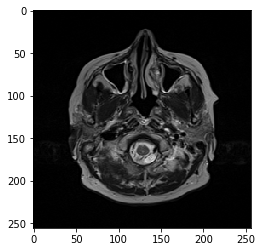

In [34]:
plt.imshow(X_train[0][0])

In [35]:
len(X_train), len(y_train)

(181, 181)

In [36]:
len(X_test), len(y_test)

(61, 61)

In [37]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
#create model
n = 243
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50, 256, 256)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit(X_train, y_train, epochs=10, batch_size = 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
181/181 [==============================] - 5s 29ms/step - loss: 15.4947 - acc: 0.0387
Epoch 2/10
181/181 [==============================] - 3s 14ms/step - loss: 15.4947 - acc: 0.0387
Epoch 3/10
181/181 [==============================] - 3s 15ms/step - loss: 15.4947 - acc: 0.0387
Epoch 4/10
181/181 [==============================] - 3s 15ms/step - loss: 15.4947 - acc: 0.0387
Epoch 5/10
181/181 [==============================] - 3s 16ms/step - loss: 15.4947 - acc: 0.0387
Epoch 6/10
181/181 [==============================] - 3s 16ms/step - loss: 15.4947 - acc: 0.0387
Epoch 7/10
181/181 [==============================] - 3s 16ms/step - loss: 15.4947 - acc: 0.0387
Epoch 8/10
181/181 [==============================] - 3s 16ms/step - loss: 15.4947 - acc: 0.0387
Epoch 9/10
181/181 [==============================] - 3s 16ms/step - loss: 15.4947 - acc: 0.0387
Epoch 10/10
181/181 [==============================] - 3s 16ms/step - loss: 15.

In [251]:
np.array(X_train).shape

(181, 50, 256, 256)

In [95]:
# model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(50,256,256))

In [116]:
with open('ids/features_test.pickle', 'rb') as handle:
    ft = pickle.load(handle)

In [133]:
ls = []
pca = PCA(20)
for f in ft['../ppmi/cd-pd/PPMI/3661/PD-T2_DUAL_AXIAL_TSE/2013-03-26_15_51_03.0/S187840\n']:
    x = pca.fit(f).singular_values_
    ls.append(x)

In [134]:
ls = np.array(ls)
ls.shape

(50, 20)

In [135]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2186885279340843869
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4105319177814360221
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3840899204227638885
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 145555456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1852758646720602581
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]
